# Build per-arm Bandit model with TF-Agents and execute locally with Vertex AI

## background

**Arm features**
* In some bandits use cases, each arm has its own features. For example, in movie recommendation problems, the user features play the role of the context and the movies play the role of the arms (aka actions) 
* Each movie has its own features, such as `text description`, `metadata`, `trailer content` features and so on

These problems are often referred to as `arm features problems`

In [1]:
! python3 -c "import google.cloud.aiplatform; print('aiplatform SDK version: {}'.format(google.cloud.aiplatform.__version__))"

aiplatform SDK version: 1.26.0


## Load env config

* use the prefix from `00-env-setup`

In [2]:
PREFIX = 'mabv1'

**run the next cell to populate env vars**

In [3]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "mabv1"
VERSION                  = "v1"

BUCKET_NAME              = "mabv1-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://mabv1-hybrid-vertex-bucket/data"
BUCKET_URI               = "gs://mabv1-hybrid-vertex-bucket"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_ID      = "hybrid-vertex.movielens_dataset_mabv1"
BIGQUERY_TABLE_ID        = "hybrid-vertex.movielens_dataset_mabv1.training_dataset"

REPO_DOCKER_PATH_PREFIX  = "src"
RL_SUB_DIR               = "per_arm_rl"



In [4]:
! gsutil ls $BUCKET_URI

gs://mabv1-hybrid-vertex-bucket/aiplatform-custom-training-2023-07-13-22:02:47.458/
gs://mabv1-hybrid-vertex-bucket/aiplatform-custom-training-2023-07-14-12:09:06.643/
gs://mabv1-hybrid-vertex-bucket/aiplatform-custom-training-2023-07-14-12:46:07.509/
gs://mabv1-hybrid-vertex-bucket/aiplatform-custom-training-2023-07-14-13:48:08.938/
gs://mabv1-hybrid-vertex-bucket/aiplatform-custom-training-2023-07-17-18:35:00.675/
gs://mabv1-hybrid-vertex-bucket/aiplatform-custom-training-2023-07-17-18:50:42.146/
gs://mabv1-hybrid-vertex-bucket/archived/
gs://mabv1-hybrid-vertex-bucket/config/
gs://mabv1-hybrid-vertex-bucket/data/
gs://mabv1-hybrid-vertex-bucket/data_stats/
gs://mabv1-hybrid-vertex-bucket/perarm-local-test/
gs://mabv1-hybrid-vertex-bucket/scale-perarm-hpt-v2/
gs://mabv1-hybrid-vertex-bucket/scale-perarm-hpt-v3/
gs://mabv1-hybrid-vertex-bucket/scale-perarm-hpt/


## imports

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [29]:
import functools
import json
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint

import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
from tf_agents.agents import TFAgent
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import (environment_utilities,
                                            movielens_py_environment,
                                            movielens_per_arm_py_environment)
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import TFEnvironment, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.metrics.tf_metric import TFStepMetric
from tf_agents.policies import policy_saver


from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec

# GPU
from numba import cuda 
import gc

# my project
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

### detect GPUs & reset devices

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [8]:
device = cuda.get_current_device()
device.reset()
gc.collect()

23

### Initialize Google Cloud SDK Clients

In [9]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

### copy sample data to $DATA_PATH

### Load data config

In [10]:
# test variables are set
print(f"USER_AGE_LOOKUP: {data_config.USER_AGE_LOOKUP}")
print(f"USER_AGE_DIM: {data_config.USER_AGE_DIM}")

print(f"USER_OCC_LOOKUP: {data_config.USER_OCC_LOOKUP}")
print(f"USER_OCC_DIM: {data_config.USER_OCC_DIM}")

print(f"MOVIE_GEN_LOOKUP: {data_config.MOVIE_GEN_LOOKUP}")
print(f"MOVIE_GEN_DIM: {data_config.MOVIE_GEN_DIM}")

print(f"MOVIELENS_NUM_MOVIES: {data_config.MOVIELENS_NUM_MOVIES}")
print(f"MOVIELENS_NUM_USERS: {data_config.MOVIELENS_NUM_USERS}")

USER_AGE_LOOKUP: {1.0: 0, 35.0: 1, 45.0: 2, 18.0: 3, 50.0: 4, 56.0: 5, 25.0: 6}
USER_AGE_DIM: 7
USER_OCC_LOOKUP: {b'homemaker': 0, b'doctor': 1, b'educator': 2, b'none': 3, b'librarian': 4, b'other': 5, b'artist': 6, b'administrator': 7, b'student': 8, b'programmer': 9, b'salesman': 10, b'healthcare': 11, b'retired': 12, b'executive': 13, b'lawyer': 14, b'entertainment': 15, b'marketing': 16, b'scientist': 17, b'engineer': 18, b'technician': 19, b'writer': 20}
USER_OCC_DIM: 21
MOVIE_GEN_LOOKUP: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18}
MOVIE_GEN_DIM: 19
MOVIELENS_NUM_MOVIES: 1682
MOVIELENS_NUM_USERS: 943


In [11]:
type(data_config.USER_OCC_LOOKUP)

dict

### Read TF Records

In [12]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [13]:
train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://mabv1-hybrid-vertex-bucket/data/ml-ratings-100k-train.tfrecord']

In [14]:
train_dataset = tf.data.TFRecordDataset(train_files)

train_dataset = train_dataset.map(data_utils.parse_tfrecord)

train_dataset

<_MapDataset element_spec={'bucketized_user_age': TensorSpec(shape=(), dtype=tf.float32, name=None), 'movie_genres': TensorSpec(shape=(1,), dtype=tf.int64, name=None), 'movie_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_occupation_text': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

In [49]:
for x in train_dataset.batch(1).take(1):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([45.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'357'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([879024327])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'138'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'doctor'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}


## calculate lookups

### user featrues

In [70]:
start_time = time.time()

user_id_lookup = tf.keras.layers.StringLookup()
user_id_lookup.adapt(train_dataset.map(lambda x: x["user_id"]))
print(f"Vocabulary user_id_lookup: {user_id_lookup.get_vocabulary()[:3]}")

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"runtime_mins: {runtime_mins}")

Vocabulary user_id_lookup: ['[UNK]', '405', '655']


In [71]:
start_time = time.time()

user_age_lookup = tf.keras.layers.IntegerLookup()
user_age_lookup.adapt(train_dataset.map(lambda x: int(x["bucketized_user_age"])))
print(f"Vocabulary user_age_lookup: {user_age_lookup.get_vocabulary()[:3]}")

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"runtime_mins: {runtime_mins}")

Vocabulary user_age_lookup: [-1, 25, 18]
runtime_mins: 2


In [72]:
start_time = time.time()

user_occ_lookup = tf.keras.layers.StringLookup()
user_occ_lookup.adapt(train_dataset.map(lambda x: x["user_occupation_text"]))
print(f"Vocabulary user_age_lookup: {user_occ_lookup.get_vocabulary()[:3]}")

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"runtime_mins: {runtime_mins}")

Vocabulary user_age_lookup: ['[UNK]', 'student', 'other']
runtime_mins: 1


In [139]:
start_time = time.time()

max_timestamp = train_dataset.map(lambda x: x["timestamp"]).reduce(
    tf.cast(0, tf.int64), tf.maximum).numpy().max()
min_timestamp = train_dataset.map(lambda x: x["timestamp"]).reduce(
    np.int64(1e9), tf.minimum).numpy().min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000)

print(f"Buckets: {timestamp_buckets[:3]}")

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"runtime_mins: {runtime_mins}")

Buckets: [8.74724710e+08 8.74743291e+08 8.74761871e+08]
runtime_mins: 0


### movie features

In [155]:
start_time = time.time()

movie_id_lookup = tf.keras.layers.StringLookup()
movie_id_lookup.adapt(train_dataset.map(lambda x: x["movie_id"]))
print(f"Vocabulary movie_id_lookup: {movie_id_lookup.get_vocabulary()[:3]}")

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"runtime_mins: {runtime_mins}")

Vocabulary movie_id_lookup: ['[UNK]', '50', '258']
runtime_mins: 1


In [156]:
start_time = time.time()

movie_gen_lookup = tf.keras.layers.IntegerLookup()
movie_gen_lookup.adapt(train_dataset.map(lambda x: int(x["movie_genres"])))
print(f"Vocabulary user_age_lookup: {movie_gen_lookup.get_vocabulary()[:3]}")

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"runtime_mins: {runtime_mins}")

Vocabulary user_age_lookup: [-1, 7, 0]
runtime_mins: 2


## create embedding layers

In [163]:
USER_EMBEDDING_SIZE = 32

### user features

In [164]:
user_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=user_id_lookup.vocab_size(),
    output_dim=USER_EMBEDDING_SIZE
)

# test 
user_id_model = tf.keras.Sequential([user_id_lookup, user_id_embedding])
user_id_model(["405"])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.02133915, -0.00847285,  0.00553839,  0.04956971, -0.04884202,
        -0.01423628,  0.0264388 , -0.04991373, -0.02720488,  0.01465893,
        -0.02321799, -0.001456  ,  0.0016151 , -0.01616285, -0.02516576,
         0.033454  , -0.00654262,  0.0121565 , -0.03020301, -0.01902446,
         0.03618702, -0.01718481, -0.02821301,  0.02466765, -0.02811155,
        -0.0439539 , -0.00154681, -0.04077569, -0.01556192, -0.02991946,
        -0.03799347,  0.02890993]], dtype=float32)>

In [177]:
user_age_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=user_age_lookup.vocab_size(),
    output_dim=USER_EMBEDDING_SIZE
)

# test 
user_age_model = tf.keras.Sequential([user_age_lookup, user_age_embedding])
user_age_model([18])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.04955554, -0.03696743, -0.02703919, -0.03803464,  0.02941333,
         0.01766728, -0.04564461, -0.04960386,  0.03014806, -0.03454351,
         0.0069787 , -0.03808462, -0.01598325,  0.03316562,  0.00559319,
         0.02124805, -0.02898613,  0.04364777,  0.01769495,  0.02354963,
         0.01089784, -0.0093568 , -0.0104007 , -0.04296106,  0.00458118,
         0.04897146, -0.01993024,  0.04496826,  0.0498344 , -0.0248399 ,
         0.00816529,  0.02084908]], dtype=float32)>

In [178]:
user_occ_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=user_occ_lookup.vocab_size(),
    output_dim=USER_EMBEDDING_SIZE
)

# test 
user_occ_model = tf.keras.Sequential([user_occ_lookup, user_occ_embedding])
user_occ_model(['student'])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.00357937,  0.00057608, -0.04822962,  0.02149484,  0.04358511,
        -0.00020391, -0.04226958, -0.03229029, -0.01697419,  0.00133302,
        -0.00420284, -0.04311797, -0.01580453,  0.03785564,  0.03659142,
        -0.0272304 ,  0.03761942,  0.03034199, -0.01186401, -0.02073176,
        -0.04327046,  0.02613885,  0.04544634,  0.0228441 , -0.01388736,
         0.0227215 ,  0.01658596,  0.03440824,  0.04198724, -0.02106375,
        -0.0093264 ,  0.01118464]], dtype=float32)>

In [179]:
timestamp_embedding_model = tf.keras.Sequential([
  tf.keras.layers.Discretization(timestamp_buckets.tolist()),
  tf.keras.layers.Embedding(len(timestamp_buckets) + 1, USER_EMBEDDING_SIZE)
])

# for timestamp in ratings.take(1).map(lambda x: x["timestamp"]).batch(1).as_numpy_iterator():
#   print(f"Timestamp embedding: {timestamp_embedding_model(timestamp)}.")
timestamp_embedding_model([879024327])

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.00066044,  0.0462102 ,  0.02651751, -0.01013513,  0.02495512,
        -0.04824067,  0.00352935,  0.00144993, -0.03210543,  0.00653744,
         0.0346578 , -0.00644116,  0.04339662,  0.0362441 , -0.02874855,
        -0.02325262, -0.01967307, -0.01586573, -0.01194584, -0.03948327,
         0.02814636, -0.04869805,  0.01532048,  0.01815101, -0.03741697,
        -0.02495186,  0.04297521, -0.02860105,  0.01560897,  0.00582739,
         0.01044911,  0.00554369]], dtype=float32)>

### movie features

In [212]:
MV_EMBEDDING_SIZE = 64

In [213]:
movie_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=movie_id_lookup.vocab_size(),
    output_dim=MV_EMBEDDING_SIZE
)

# test 
mv_id_model = tf.keras.Sequential([movie_id_lookup, movie_id_embedding])
mv_id_model(["357"])

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[ 3.08278315e-02,  4.26267870e-02, -1.39455311e-02,
        -3.25039253e-02, -2.83411983e-02,  2.11210288e-02,
         1.29451491e-02,  1.42774470e-02,  1.96418427e-02,
         6.03280962e-04,  2.89575495e-02, -1.73527971e-02,
         1.16245821e-03, -1.09732263e-02,  1.39176510e-02,
         2.09697820e-02, -2.79950034e-02,  5.65215200e-03,
        -2.23914534e-03,  3.22854035e-02,  1.38306729e-02,
        -1.04766004e-02, -1.42583735e-02, -7.60564953e-03,
         3.28443684e-02,  1.06181502e-02, -3.21645364e-02,
        -4.49722670e-02,  8.46122578e-03, -4.96131778e-02,
         3.76042463e-02, -4.01291847e-02, -4.57051881e-02,
         4.50771339e-02,  4.67248075e-02,  1.86170824e-02,
        -2.78911721e-02, -2.72371415e-02, -1.82448402e-02,
         8.78946856e-03, -4.50686812e-02,  4.26644720e-02,
        -3.28459144e-02, -9.63952392e-03,  1.40556954e-02,
        -6.43993542e-03, -2.84257885e-02,  3.23246382e-02,
       

In [214]:
movie_gen_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=movie_gen_lookup.vocab_size(),
    output_dim=MV_EMBEDDING_SIZE
)

# test 
mv_gen_model = tf.keras.Sequential([movie_gen_lookup, movie_gen_embedding])
mv_gen_model([7])

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([-4.58238013e-02,  5.81582636e-03, -3.76645476e-03, -1.93797238e-02,
        3.73208858e-02,  1.39762871e-02,  3.03233787e-03,  1.42685510e-02,
       -3.50592285e-03, -2.16763150e-02,  3.88072766e-02,  1.18336901e-02,
        3.39148678e-02, -3.98270786e-05,  4.69145291e-02,  3.98651846e-02,
        3.21034454e-02,  2.10494660e-02,  2.53681056e-02, -2.59850156e-02,
        4.71412279e-02, -3.27730551e-02,  3.81659605e-02,  3.13382037e-02,
        2.74869055e-03, -2.93345805e-02, -3.16557437e-02,  1.16098896e-02,
       -2.56407261e-02,  5.22757694e-03, -4.34020273e-02,  1.72342919e-02,
        4.45606373e-02, -1.13725178e-02, -2.11489201e-03,  3.73524539e-02,
       -4.85084206e-03,  1.27805360e-02,  1.22262947e-02, -1.55347958e-02,
       -1.06399767e-02,  2.09057964e-02, -4.63314317e-02,  2.76353471e-02,
        1.58879496e-02,  3.94936539e-02, -4.59056981e-02, -2.77342442e-02,
        2.02686712e-03, -1.43091679e-02, -3.97934802e

### test concat

In [81]:
test_id_value = user_id_model(["405"]).numpy()

print(test_id_value.shape)
test_id_value

(1, 32)


array([[-0.02592905,  0.04963319, -0.03509563,  0.00360916, -0.03130561,
         0.04330171,  0.01078621, -0.02183689,  0.04216427,  0.02194181,
         0.00648174,  0.00144852, -0.00538989, -0.00426998, -0.0305585 ,
        -0.02309582,  0.02268947, -0.02398355,  0.02846402, -0.00684224,
        -0.01771741, -0.0222518 , -0.02820476,  0.02480245, -0.0310462 ,
         0.04410451, -0.04268888,  0.02448532, -0.04435045, -0.04490483,
         0.03554393, -0.02463512]], dtype=float32)

In [82]:
test_age_value = user_age_model([18]).numpy()

print(test_age_value.shape)
test_age_value

(1, 32)


array([[-0.02379255,  0.04369508,  0.02165151, -0.02074115,  0.01820816,
        -0.03143139,  0.01334475, -0.01282028,  0.03167496,  0.0029224 ,
        -0.02275851, -0.00485495, -0.01782919,  0.0149723 ,  0.0330332 ,
         0.00656012, -0.00169833,  0.03387184, -0.03083158, -0.0168779 ,
         0.00936011,  0.0053486 ,  0.01424874, -0.00229301, -0.00721395,
         0.01856655,  0.0414192 ,  0.01789801,  0.04218565, -0.03640497,
        -0.04073054, -0.0429283 ]], dtype=float32)

In [83]:
test_occ_value = user_occ_model(['student']).numpy()

print(test_occ_value.shape)
test_occ_value

(1, 32)


array([[ 0.03178695, -0.0353423 ,  0.0002742 ,  0.01620188,  0.01725006,
        -0.02861638, -0.01205734,  0.01757014, -0.03417969,  0.02328005,
         0.03930822, -0.00564992,  0.03237546, -0.00562776,  0.03641622,
        -0.01852721, -0.03211895,  0.03783574, -0.00918182, -0.03582566,
         0.01940243,  0.02046399, -0.00882613,  0.03882194,  0.04925608,
        -0.04498097, -0.01861153, -0.02901036,  0.01418642, -0.03193836,
        -0.04334359, -0.02535138]], dtype=float32)

In [84]:
combined_user_features = np.concatenate(
    (
        test_id_value,
        test_age_value,
        test_occ_value
    )
    , axis=1
)

combined_user_features

array([[-0.02592905,  0.04963319, -0.03509563,  0.00360916, -0.03130561,
         0.04330171,  0.01078621, -0.02183689,  0.04216427,  0.02194181,
         0.00648174,  0.00144852, -0.00538989, -0.00426998, -0.0305585 ,
        -0.02309582,  0.02268947, -0.02398355,  0.02846402, -0.00684224,
        -0.01771741, -0.0222518 , -0.02820476,  0.02480245, -0.0310462 ,
         0.04410451, -0.04268888,  0.02448532, -0.04435045, -0.04490483,
         0.03554393, -0.02463512, -0.02379255,  0.04369508,  0.02165151,
        -0.02074115,  0.01820816, -0.03143139,  0.01334475, -0.01282028,
         0.03167496,  0.0029224 , -0.02275851, -0.00485495, -0.01782919,
         0.0149723 ,  0.0330332 ,  0.00656012, -0.00169833,  0.03387184,
        -0.03083158, -0.0168779 ,  0.00936011,  0.0053486 ,  0.01424874,
        -0.00229301, -0.00721395,  0.01856655,  0.0414192 ,  0.01789801,
         0.04218565, -0.03640497, -0.04073054, -0.0429283 ,  0.03178695,
        -0.0353423 ,  0.0002742 ,  0.01620188,  0.0

In [86]:
combined_user_features.shape[1]

96

In [110]:
# for x in train_dataset.batch(1).take(1):
#     user_id_value = x['user_id'].numpy().tolist()[0],
#     user_age_value = int(x['bucketized_user_age'].numpy().tolist()[0]),
#     user_occ_value = x['user_occupation_text'].numpy().tolist()[0]

#     print(user_id_value)
#     print(user_age_value)
#     print(user_occ_value)
    
#     id_emb = user_id_model([user_id_value[0].decode('utf-8')])
#     age_emb = user_age_model([user_age_value[0]])
#     occ_emb = user_occ_model([user_occ_value.decode('utf-8')])
    
#     print(id_emb.shape)
#     print(age_emb.shape)
#     print(occ_emb.shape)
    
#     combined_user_features = np.concatenate(
#         (
#             id_emb,
#             age_emb,
#             occ_emb
#         )
#         , axis=1
#     )
#     print(combined_user_features.shape)

(b'138',)
(45,)
b'doctor'
(1, 32)
(1, 32)
(1, 32)
(1, 96)


In [103]:
user_id_value[0].decode('utf-8')

'138'

In [105]:
user_age_value[0]

45

In [107]:
user_occ_value.decode('utf-8')

'doctor'

In [149]:
for x in train_dataset.take(1).as_numpy_iterator():
    user_id_value = x['user_id']
    user_age_value = x['bucketized_user_age']
    user_occ_value = x['user_occupation_text']
    user_ts_value = x['timestamp']

    # print(user_id_value[0].decode('utf-8'))
    # print(int(user_age_value[0]))
    # print(user_occ_value.decode('utf-8'))
    
    print(str(user_id_value.decode('utf-8')))
    print(int(user_age_value))
    print(user_occ_value.decode('utf-8'))
    print(user_ts_value)
    
    id_emb = user_id_model([str(user_id_value.decode('utf-8'))])
    age_emb = user_age_model([int(user_age_value)])
    occ_emb = user_occ_model([user_occ_value.decode('utf-8')])
    ts_emb = timestamp_embedding_model([user_ts_value])
    
    print(id_emb.shape)
    print(age_emb.shape)
    print(occ_emb.shape)
    print(ts_emb.shape)
    
    combined_user_features = np.concatenate(
        (
            id_emb,
            age_emb,
            occ_emb,
            ts_emb
        )
        , axis=1
    )
    print(combined_user_features.shape)

138
45
doctor
879024327
(1, 32)
(1, 32)
(1, 32)
(1, 32)
(1, 128)


## global input functions

In [250]:
EMBEDDING_SIZE = 32

def global_context_sampling_fn():
    """
    This function generates a single global observation vector.
    """
    for x in train_dataset.take(1).as_numpy_iterator():
        user_id_value = x['user_id']
        user_age_value = x['bucketized_user_age']
        user_occ_value = x['user_occupation_text']
        user_ts_value = x['timestamp']
        
        # print(str(user_id_value.decode('utf-8')))
        # print(int(user_age_value))
        # print(user_occ_value.decode('utf-8'))
        # print(user_ts_value)
        
        id_emb = user_id_model([str(user_id_value.decode('utf-8'))])
        age_emb = user_age_model([int(user_age_value)])
        occ_emb = user_occ_model([user_occ_value.decode('utf-8')])
        ts_emb = timestamp_embedding_model([user_ts_value])

        # print(id_emb.shape)
        # print(age_emb.shape)
        # print(occ_emb.shape)
        # print(ts_emb.shape)

        combined_user_features = np.concatenate(
            (
                id_emb,
                age_emb,
                occ_emb,
                ts_emb
            )
            , axis=1
        )

    return combined_user_features

global_con = global_context_sampling_fn()
print(global_con.shape)
global_con

(1, 128)


array([[-8.5508823e-03, -4.8447624e-03,  1.8828992e-02,  2.7534548e-02,
        -1.5263185e-03, -7.9958811e-03,  2.3095980e-03,  2.1651689e-02,
         4.1292641e-02, -7.6190829e-03,  3.1629551e-02,  1.9993670e-03,
        -2.1431930e-03,  4.5911226e-02,  4.8037682e-02, -1.7330516e-02,
         3.8603257e-02,  4.7624335e-03,  1.5749265e-02,  3.5174195e-02,
        -1.8469024e-02, -3.0042959e-02,  3.9486576e-02,  9.4417110e-03,
         4.5821939e-02, -3.3114873e-02,  1.9345928e-02,  4.0754054e-02,
         4.1269254e-02, -3.7472237e-02,  2.2480417e-02,  9.7856410e-03,
         3.9251816e-02, -1.6916394e-02,  5.2018650e-03, -2.4589265e-02,
        -1.7954599e-02, -4.9004704e-04,  1.7117858e-03, -4.8918139e-02,
         2.8843060e-03,  1.5893247e-02, -7.7363364e-03,  3.7663709e-02,
        -3.0551303e-02,  4.3893162e-02, -8.6724758e-05, -4.8247017e-02,
         3.3032186e-03,  4.7936551e-03,  2.8672185e-02,  4.4083003e-02,
        -2.9565429e-02, -3.6866151e-02,  3.7373293e-02,  8.72050

In [251]:
def per_arm_context_sampling_fn():
    """
    This function generates a single per-arm observation vector
    """
    for x in train_dataset.take(1).as_numpy_iterator():
        mv_id_value = x['movie_id']
        mv_gen_value = x['movie_genres'][0]
        
        # print(mv_id_value)
        # print(mv_gen_value)
        
        mv_id_emb = mv_id_model([str(mv_id_value.decode('utf-8'))])
        mv_gen_emb = mv_gen_model([int(mv_gen_value)])
        
        # print(mv_id_emb.shape)
        # print(mv_gen_emb.shape)
        
        combined_mv_features = np.concatenate(
            (
                mv_id_emb,
                tf.expand_dims(mv_gen_emb, axis=0)
            )
            , axis=1
        )
        
    return combined_mv_features

global_arm = per_arm_context_sampling_fn()
print(global_arm.shape)
global_arm

# per_arm_context_sampling_fn(dataset = train_dataset)

(1, 128)


array([[ 3.08278315e-02,  4.26267870e-02, -1.39455311e-02,
        -3.25039253e-02, -2.83411983e-02,  2.11210288e-02,
         1.29451491e-02,  1.42774470e-02,  1.96418427e-02,
         6.03280962e-04,  2.89575495e-02, -1.73527971e-02,
         1.16245821e-03, -1.09732263e-02,  1.39176510e-02,
         2.09697820e-02, -2.79950034e-02,  5.65215200e-03,
        -2.23914534e-03,  3.22854035e-02,  1.38306729e-02,
        -1.04766004e-02, -1.42583735e-02, -7.60564953e-03,
         3.28443684e-02,  1.06181502e-02, -3.21645364e-02,
        -4.49722670e-02,  8.46122578e-03, -4.96131778e-02,
         3.76042463e-02, -4.01291847e-02, -4.57051881e-02,
         4.50771339e-02,  4.67248075e-02,  1.86170824e-02,
        -2.78911721e-02, -2.72371415e-02, -1.82448402e-02,
         8.78946856e-03, -4.50686812e-02,  4.26644720e-02,
        -3.28459144e-02, -9.63952392e-03,  1.40556954e-02,
        -6.43993542e-03, -2.84257885e-02,  3.23246382e-02,
        -1.84206367e-02,  3.72829922e-02,  1.80780031e-0

## reward function

In [241]:
# global_con[0]
global_con[0].shape

(128,)

In [240]:
# global_arm[0] #[0]
global_arm[0].shape

(128,)

In [232]:
inner_prod = np.dot(global_arm[0], global_con[0])
inner_prod

0.004005814

In [244]:
reward_param = np.concatenate(
    (
        global_con[0],
        global_arm[0]
    )
)
reward_param.shape

(256,)

In [235]:
# def linear_normal_reward_fn(context_features, arm_features):
#     """
#     This function generates a reward from the concatenated global and per-arm observations.
#     """
#     inner_prod = np.dot(context_features, arm_features)
#     return inner_prod

In [236]:
# linear_normal_reward_fn(global_arm[0], global_con[0])

0.004005814

In [252]:
# The dimension of the global features.
GLOBAL_DIM = global_con.shape[1] 

PER_ARM_DIM = global_arm.shape[1]  
# The elements of the PER-ARM feature will be integers in [-PER_ARM_BOUND, PER_ARM_BOUND).

NUM_ACTIONS = 70 
BATCH_SIZE = 20

# The variance of the Gaussian distribution that generates the rewards.
VARIANCE = 100.0

reward_param = np.concatenate(
    (
        global_con[0],
        global_arm[0]
    )
)
# reward_param.shape

print(f"GLOBAL_DIM   : {GLOBAL_DIM}")
print(f"PER_ARM_DIM  : {PER_ARM_DIM}")
print(f"NUM_ACTIONS  : {NUM_ACTIONS}")
print(f"BATCH_SIZE   : {BATCH_SIZE}")

GLOBAL_DIM   : 128
PER_ARM_DIM  : 128
NUM_ACTIONS  : 70
BATCH_SIZE   : 20


In [253]:
def linear_normal_reward_fn(x):
    """This function generates a reward from the concatenated global and per-arm observations."""
    mu = np.dot(x, reward_param)
    return np.random.normal(mu, VARIANCE)

In [254]:
linear_normal_reward_fn

<function __main__.linear_normal_reward_fn(x)>

In [255]:
from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env

per_arm_py_env = p_a_env.StationaryStochasticPerArmPyEnvironment(
    global_context_sampling_fn,
    per_arm_context_sampling_fn,
    NUM_ACTIONS,
    linear_normal_reward_fn,
    batch_size=BATCH_SIZE
)
per_arm_tf_env = tf_py_environment.TFPyEnvironment(per_arm_py_env)

In [ ]:
print('observation spec: ', per_arm_tf_env.observation_spec())
print('\nAn observation: ', per_arm_tf_env.reset().observation)

action = tf.zeros(BATCH_SIZE, dtype=tf.int32)
time_step = per_arm_tf_env.step(action)
print('\nRewards after taking an action: ', time_step.reward)

observation spec:  {'global': TensorSpec(shape=(1, 128), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(70, 1, 128), dtype=tf.float32, name=None)}


# Define RL modules

In [16]:
# REPO_DOCKER_PATH_PREFIX = 'src'
# RL_SUB_DIR = 'per_arm_rl'

# TODO - fix between 00-data notebook
# ! rm -rf {REPO_DOCKER_PATH_PREFIX}/{RL_SUB_DIR}
# ! mkdir -p {REPO_DOCKER_PATH_PREFIX}/{RL_SUB_DIR}
# ! touch {REPO_DOCKER_PATH_PREFIX}/{RL_SUB_DIR}/__init__.py

### per_arm environment

In [17]:
%%writefile {REPO_DOCKER_PATH_PREFIX}/{RL_SUB_DIR}/my_per_arm_py_env.py
# Copyright 2021 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#            http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
"""Class implementation of the per-arm MovieLens Bandit environment."""
from __future__ import absolute_import
import os
import gin
import random
import numpy as np
from typing import Optional, Text

import logging

import tensorflow as tf

tf.compat.v1.enable_v2_behavior()

from tf_agents.bandits.environments import bandit_py_environment
from tf_agents.bandits.environments import dataset_utilities
from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts

from . import data_utils

GLOBAL_KEY = bandit_spec_utils.GLOBAL_FEATURE_KEY
PER_ARM_KEY = bandit_spec_utils.PER_ARM_FEATURE_KEY

# @gin.configurable
class MyMovieLensPerArmPyEnvironment(bandit_py_environment.BanditPyEnvironment):
    """Implements the per-arm version of the MovieLens Bandit environment.

    This environment implements the MovieLens 100K dataset, available at:
    https://www.kaggle.com/prajitdatta/movielens-100k-dataset

    This dataset contains 100K ratings from 943 users on 1682 items.
    This environment computes a low-rank matrix factorization (using SVD) of the
    data matrix `A`, such that: `A ~= U * Sigma * V^T`.

    The environment uses the rows of `U` as global (or user) features, and the
    rows of `V` as per-arm (or movie) features.

    The reward of recommending movie `v` to user `u` is `u * Sigma * v^T`.
    """

    def __init__(
        self
        , project_number
        , data_path: str
        , bucket_name: str
        , data_gcs_prefix: str
        , user_age_lookup_dict: dict
        , user_occ_lookup_dict: dict
        , movie_gen_lookup_dict: dict
        , num_users: int = 943
        , num_movies: int = 1682
        , rank_k: int = 2
        , batch_size: int = 10
        , num_actions: int = 100
        , name: Optional[Text] = 'movielens_per_arm'
    ):
        """Initializes the Per-arm MovieLens Bandit environment.

        Args:
          data_dir: (string) Directory where the data lies (in text form).
          rank_k : (int) Which rank to use in the matrix factorization. This will
            also be the feature dimension of both the user and the movie features.
          batch_size: (int) Number of observations generated per call.
          num_actions: (int) How many movies to choose from per round.
          name: (string) The name of this environment instance.
        """
        self.project_number = project_number
        self.data_path = data_path
        self.bucket_name = bucket_name
        self.data_gcs_prefix = data_gcs_prefix
        self._batch_size = batch_size
        self._num_actions = num_actions
        self._rank_k = rank_k
        self.num_users = num_users
        self.num_movies = num_movies
        self.user_age_lookup_dict = user_age_lookup_dict
        self.user_occ_lookup_dict = user_occ_lookup_dict
        self.movie_gen_lookup_dict = movie_gen_lookup_dict
        
        # =============================================
        # set GCP clients
        # =============================================
        from google.cloud import aiplatform as vertex_ai
        from google.cloud import storage
        
        # project_number = os.environ["CLOUD_ML_PROJECT_ID"]
        storage_client = storage.Client(project=self.project_number)
        vertex_ai.init(
            project=self.project_number,
            location='us-central1',
            # experiment=args.experiment_name
        )
        
        # =============================================
        # GPUs
        # =============================================
        
        # limiting GPU growth
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                logging.info(f'detected: {len(gpus)} GPUs')
            except RuntimeError as e:
                # Memory growth must be set before GPUs have been initialized
                logging.info(e)

        # tf.debugging.set_log_device_placement(True)        # logs all tf ops and their device placement;
        os.environ['TF_GPU_THREAD_MODE']='gpu_private'
        os.environ['TF_GPU_THREAD_COUNT']=f'8'               # TODO - parametrize | 1
        os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
        
        # =============================================
        # get TF dataset
        # =============================================
        logging.info("Creating TRAIN dataset...")
        logging.info(f'Path to TRAIN files: gs://{self.bucket_name}/{self.data_gcs_prefix}')
        
        options = tf.data.Options()
        options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
        
        train_files = []
        for blob in storage_client.list_blobs(f"{self.bucket_name}", prefix=f'{self.data_gcs_prefix}/'):
            if '.tfrecord' in blob.name:
                train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
                
        logging.info(f'train_files: {train_files}')
        
        train_dataset = tf.data.TFRecordDataset(train_files)
        train_dataset = train_dataset.map(data_utils.parse_tfrecord)
        
        self.dataset = train_dataset
        # =============================================
        # load data & compute ratings matrix
        # =============================================
        self._data_matrix, self._user_age_int, self._user_occ_int, self._mov_gen_int = data_utils.load_movielens_ratings(
            ratings_dataset = self.dataset
            , num_users = self.num_users
            , num_movies = self.num_movies
            , user_age_lookup_dict = self.user_age_lookup_dict
            , user_occ_lookup_dict = self.user_occ_lookup_dict
            , movie_gen_lookup_dict = self.movie_gen_lookup_dict
        )
        self._num_users, self._num_movies = self._data_matrix.shape
        
        # Compute the SVD.
        # TODO - compute SVD in tf - see: https://www.tensorflow.org/api_docs/python/tf/linalg/svd
        u, s, vh = np.linalg.svd(self._data_matrix, full_matrices=False)
        
        # Keep only the largest singular values.
        self._u_hat = u[:, :self._rank_k].astype(np.float32)
        self._s_hat = s[:self._rank_k].astype(np.float32)
        self._v_hat = np.transpose(vh[:self._rank_k]).astype(np.float32)

        self._approx_ratings_matrix = np.matmul(
            self._u_hat * self._s_hat
            , np.transpose(self._v_hat)
        )
        
        # =============================================
        # action spec
        # =============================================
        self._action_spec = array_spec.BoundedArraySpec(
            shape=()
            , dtype=np.int32
            , minimum=0
            , maximum=self._num_actions - 1
            , name='action'
        )
        
        # =============================================
        # observation spec
        # =============================================
        observation_spec = {
            GLOBAL_KEY:
                array_spec.ArraySpec(shape=[self._rank_k + 2], dtype=np.float32),     # creating +space for user age and occupation
            PER_ARM_KEY:
                array_spec.ArraySpec(
                    shape=[self._num_actions, self._rank_k + 1], dtype=np.float32),   # creating +1 space for movie genre
        }
        self._time_step_spec = ts.time_step_spec(observation_spec)

        self._current_user_indices = np.zeros(self._batch_size, dtype=np.int32)
        self._previous_user_indices = np.zeros(self._batch_size, dtype=np.int32)

        self._current_movie_indices = np.zeros(
            [self._batch_size, self._num_actions], dtype=np.int32
        )
        self._previous_movie_indices = np.zeros(
            [self._batch_size, self._num_actions], dtype=np.int32
        )
        
        self._observation = {
            GLOBAL_KEY:
                np.zeros([self._batch_size, self._rank_k + 2], dtype=np.int32), #making space like above for dimensions
            PER_ARM_KEY:
                np.zeros([self._batch_size, self._num_actions, self._rank_k + 1], dtype=np.int32),
        }
        
        # =============================================
        # super init
        # =============================================
        super(MyMovieLensPerArmPyEnvironment, self).__init__(
            observation_spec, self._action_spec, name=name
        )
        
    # =============================================
    # batched observations
    # =============================================
    @property
    def batch_size(self):
        return self._batch_size

    @property
    def batched(self):
        return True

    def _observe(self):
        sampled_user_indices = np.random.randint(
            self._num_users, size=self._batch_size
        )
        self._previous_user_indices = self._current_user_indices
        self._current_user_indices = sampled_user_indices

        sampled_movie_indices = np.array([
            random.sample(range(self._num_movies), self._num_actions)
            for _ in range(self._batch_size)
        ])
        sampled_user_ages = self._user_age_int[sampled_user_indices]
        sampled_user_occ = self._user_occ_int[sampled_user_indices]
        combined_user_features = np.concatenate(
            (
                self._u_hat[sampled_user_indices]
                , sampled_user_ages.reshape(-1,1)
                , sampled_user_occ.reshape(-1,1)
            )
            , axis=1
        )
        # current_users = combined_user_features.reshape([self.batch_size, self._rank_k+2])
        
        movie_index_vector = sampled_movie_indices.reshape(-1)
        # print(movie_index_vector.shape)
        flat_genre_list = self._mov_gen_int[movie_index_vector] # shape of 1
        flat_movie_list = self._v_hat[movie_index_vector]       # shape of 2
        
        combined_movie_features = np.concatenate(
            (
                flat_movie_list
                , flat_genre_list.reshape(-1,1)
            )
            , axis=1
        )
        current_movies = combined_movie_features.reshape(
            [self._batch_size, self._num_actions, self._rank_k + 1]
        )

        self._previous_movie_indices = self._current_movie_indices
        self._current_movie_indices = sampled_movie_indices

        batched_observations = {
            GLOBAL_KEY:
                tf.convert_to_tensor(combined_user_features, dtype=tf.float32),
            PER_ARM_KEY:
                tf.convert_to_tensor(current_movies, dtype=tf.float32),
        }
        return batched_observations

    def _apply_action(self, action):
        chosen_arm_indices = self._current_movie_indices[
            range(self._batch_size), action
        ]
        return self._approx_ratings_matrix[
            self._current_user_indices, chosen_arm_indices
        ]

    def _rewards_for_all_actions(self):
        rewards_matrix = self._approx_ratings_matrix[
            np.expand_dims(self._previous_user_indices, axis=-1)
            , self._previous_movie_indices
        ]
        return rewards_matrix

    def compute_optimal_action(self):
        return np.argmax(self._rewards_for_all_actions(), axis=-1)

    def compute_optimal_reward(self):
        return np.max(self._rewards_for_all_actions(), axis=-1)

Overwriting src/per_arm_rl/my_per_arm_py_env.py


# Train RL modules

In [18]:
from src.per_arm_rl import my_per_arm_py_env as my_per_arm_py_env

### set hyperparameters

In [19]:
# Set hyperparameters.
BATCH_SIZE       = 8      # Training and prediction batch size.
TRAINING_LOOPS   = 10      # Number of training iterations.
STEPS_PER_LOOP   = 6      # Number of driver steps per training iteration.

# Set MovieLens simulation environment parameters.
RANK_K           = 20     # Rank for matrix factorization in the MovieLens environment; also the observation dimension.
NUM_ACTIONS      = 20     # Number of actions (movie items) to choose from.
PER_ARM          = True   # Use the non-per-arm version of the MovieLens environment.

# Set agent parameters.
TIKHONOV_WEIGHT  = 0.001   # LinUCB Tikhonov regularization weight.
AGENT_ALPHA      = 10.0    # LinUCB exploration parameter that multiplies the confidence intervals.

print(f"BATCH_SIZE       : {BATCH_SIZE}")
print(f"TRAINING_LOOPS   : {TRAINING_LOOPS}")
print(f"STEPS_PER_LOOP   : {STEPS_PER_LOOP}")
print(f"RANK_K           : {RANK_K}")
print(f"NUM_ACTIONS      : {NUM_ACTIONS}")
print(f"PER_ARM          : {PER_ARM}")
print(f"TIKHONOV_WEIGHT  : {TIKHONOV_WEIGHT}")
print(f"AGENT_ALPHA      : {AGENT_ALPHA}")

BATCH_SIZE       : 8
TRAINING_LOOPS   : 10
STEPS_PER_LOOP   : 6
RANK_K           : 20
NUM_ACTIONS      : 20
PER_ARM          : True
TIKHONOV_WEIGHT  : 0.001
AGENT_ALPHA      : 10.0


### Define RL environment

One can define a bandit environment by subclassing `BanditTFEnvironment`, or, similarly to RL environments, one can define a `BanditPyEnvironment` and wrap it with `TFPyEnvironment`

In [21]:
env = my_per_arm_py_env.MyMovieLensPerArmPyEnvironment(
    project_number = PROJECT_NUM
    , data_path = DATA_PATH
    , bucket_name = BUCKET_NAME
    , data_gcs_prefix = DATA_GCS_PREFIX
    , user_age_lookup_dict = data_config.USER_AGE_LOOKUP
    , user_occ_lookup_dict = data_config.USER_OCC_LOOKUP
    , movie_gen_lookup_dict = data_config.MOVIE_GEN_LOOKUP
    , num_users = data_config.MOVIELENS_NUM_USERS
    , num_movies = data_config.MOVIELENS_NUM_MOVIES
    , rank_k = RANK_K
    , batch_size = BATCH_SIZE
    , num_actions = NUM_ACTIONS
)

environment = tf_py_environment.TFPyEnvironment(env)

In [22]:
print('observation spec: ', environment.observation_spec())
print('\nAn observation: ', environment.reset().observation)

action = tf.zeros(BATCH_SIZE, dtype=tf.int32)
time_step = environment.step(action)
print('\nRewards after taking an action: ', time_step.reward)

observation spec:  {'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(20, 21), dtype=tf.float32, name=None)}

An observation:  {'global': <tf.Tensor: shape=(8, 22), dtype=float32, numpy=
array([[-2.28528548e-02, -3.51785943e-02, -3.05424985e-02,
        -3.92608456e-02,  2.89941318e-02, -9.31560155e-03,
         2.95473784e-02,  4.05030102e-02, -1.04723804e-01,
        -4.41837572e-02,  3.32700983e-02,  7.12576136e-02,
        -3.18237469e-02,  4.58331257e-02, -4.35423851e-02,
         3.39798443e-02,  5.78484125e-02,  3.90710557e-06,
         1.82714015e-02,  9.83974338e-03,  4.00010014e+00,
         2.00009990e+00],
       [-3.88121768e-03, -2.10101362e-02,  1.87191181e-02,
        -2.26724315e-02, -2.37291846e-02,  1.20723969e-03,
         8.09682161e-03,  1.28388021e-03, -1.68351661e-02,
        -6.52995287e-03,  6.31455623e-04, -1.49870189e-02,
        -9.42895305e-04, -7.06600258e-03, -2.54058447e-02,
         8.35340106e-05,  1.90908108

### Define RL agent/algorithm

In [24]:
observation_spec = environment.observation_spec()
observation_spec

{'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(20, 21), dtype=tf.float32, name=None)}

In [27]:
time_step_spec = ts.time_step_spec(observation_spec)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(20, 21), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [30]:
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=NUM_ACTIONS - 1)

action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(19, dtype=int32))

In [32]:
# agent = lin_ucb_agent.LinearUCBAgent(
#     time_step_spec = environment.time_step_spec()
#     , action_spec = environment.action_spec()
#     , tikhonov_weight = TIKHONOV_WEIGHT
#     , alpha = AGENT_ALPHA
#     , dtype = tf.float32
#     , accepts_per_arm_features = PER_ARM
# )

agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    accepts_per_arm_features=True
)

In [33]:
print("TimeStep Spec (for each batch):\n", agent.time_step_spec, "\n")

TimeStep Spec (for each batch):
 TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': DictWrapper({'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(20, 21), dtype=tf.float32, name=None)}),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}) 



In [34]:
print("Action Spec (for each batch)  :\n", agent.action_spec, "\n")

Action Spec (for each batch)  :
 BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(19, dtype=int32)) 



In [35]:
print("Reward Spec (for each batch)  :\n", environment.reward_spec(), "\n")

Reward Spec (for each batch)  :
 TensorSpec(shape=(), dtype=tf.float32, name='reward') 



In [36]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(19, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(21,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


In [37]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None)}


In [38]:
print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

chosen arm features:  TensorSpec(shape=(21,), dtype=tf.float32, name=None)


### Define RL metric

Bandits' most important metric is **regret**, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The [RegretMetric](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_metrics.py) thus needs a `baseline_reward_fn` function that calculates the best achievable expected reward given an observation. For our example, we need to take the maximum of the no-noise equivalents of the reward functions that we already defined for the environment.

In [39]:
# optimal_reward_fn = functools.partial(
#     environment_utilities.compute_optimal_reward_with_movielens_environment
#     , environment=environment
# )

# regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)

# metrics = [regret_metric]


def _all_rewards(observation, hidden_param):
    """Outputs rewards for all actions, given an observation."""
    hidden_param = tf.cast(hidden_param, dtype=tf.float32)
    global_obs = observation['global']
    per_arm_obs = observation['per_arm']
    num_actions = tf.shape(per_arm_obs)[1]
    tiled_global = tf.tile(
        tf.expand_dims(global_obs, axis=1), [1, num_actions, 1])
    concatenated = tf.concat([tiled_global, per_arm_obs], axis=-1)
    rewards = tf.linalg.matvec(concatenated, hidden_param)
    return rewards

def optimal_reward(observation):
    """Outputs the maximum expected reward for every element in the batch."""
    return tf.reduce_max(_all_rewards(observation, reward_param), axis=1)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward)

In [40]:
regret_metric

## Train (locally)

A **policy** in a bandit problem works the same way as in an RL problem: it provides an action (or a distribution of actions), given an observation as input.
* For more details, see the [TF-Agents Policy tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/3_policies_tutorial.ipynb).
* As with environments, there are two ways to construct a policy: One can create a `PyPolicy` and wrap it with `TFPyPolicy`, or directly create a `TFPolicy`

**Replay buffers**
* Reinforcement learning algorithms use `replay buffers` to store trajectories of experience when executing a policy in an environment. * During training, replay buffers are queried for a subset of the trajectories (either a sequential subset or a sample) to "replay" the agent's experience.

### Define the training logic (on-policy training)

> The following function is the same as [trainer.train](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py#L130), but it keeps track of intermediate metric values and saves different artifacts to different locations. You can also directly invoke [trainer.train](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py#L130) which also trains the policy.

In [41]:
num_iterations = 20 # @param
steps_per_loop = 1 # @param

In [43]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=steps_per_loop)
replay_buffer

In [45]:
observers = [replay_buffer.add_batch, regret_metric]
observers

[<bound method ReplayBuffer.add_batch of <tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer object at 0x7f0f981d0f10>>,

In [47]:
driver = dynamic_step_driver.DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * BATCH_SIZE,
    observers=observers)

driver

In [48]:
regret_values = []

for _ in range(num_iterations):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

/home/jupyter/.local/lib/python3.10/site-packages/tf_agents/utils/common.py:1443: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return state is not None and state is not () and state is not []
/home/jupyter/.local/lib/python3.10/site-packages/tf_agents/utils/common.py:1443: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return state is not None and state is not () and state is not []


NameError: name 'reward_param' is not defined

In [ ]:

plt.plot(regret_values)
plt.title('Regret of LinUCB on the Linear per-arm environment')
plt.xlabel('Number of Iterations')
_ = plt.ylabel('Average Regret')

In [97]:
# def train(
#     root_dir: str,
#     agent: TFAgent,
#     environment: TFEnvironment,
#     training_loops: int,
#     steps_per_loop: int,
#     additional_metrics: Optional[List[TFStepMetric]] = None,
#     training_data_spec_transformation_fn: Optional[Callable[[T], T]] = None,
# ) -> Dict[str, List[float]]:
#     """Performs `training_loops` iterations of training on the agent's policy.

#     Uses the `environment` as the problem formulation and source of immediate
#     feedback and the agent's algorithm, to perform `training-loops` iterations
#     of on-policy training on the policy.
#     If one or more baseline_reward_fns are provided, the regret is computed
#     against each one of them. Here is example baseline_reward_fn:
#     def baseline_reward_fn(observation, per_action_reward_fns):
#         rewards = ... # compute reward for each arm
#         optimal_action_reward = ... # take the maximum reward
#         return optimal_action_reward

#     Args:
#         root_dir: Path to the directory where training artifacts are written.
#         agent: An instance of `TFAgent`.
#         environment: An instance of `TFEnvironment`.
#         training_loops: An integer indicating how many training loops should be run.
#         steps_per_loop: An integer indicating how many driver steps should be
#            executed and presented to the trainer during each training loop.
#         additional_metrics: Optional; list of metric objects to log, in addition to
#           default metrics `NumberOfEpisodes`, `AverageReturnMetric`, and
#           `AverageEpisodeLengthMetric`.
#         training_data_spec_transformation_fn: Optional; function that transforms
#           the data items before they get to the replay buffer.

#     Returns:
#         A dict mapping metric names (eg. "AverageReturnMetric") to a list of
#         intermediate metric values over `training_loops` iterations of training.
#     """
    
#     # ====================================================
#     # get data spec
#     # ====================================================
#     if training_data_spec_transformation_fn is None:
#         data_spec = agent.policy.trajectory_spec
#     else:
#         data_spec = training_data_spec_transformation_fn(
#             agent.policy.trajectory_spec
#         )
        
#     # ====================================================
#     # define replay buffer
#     # ====================================================
#     replay_buffer = trainer._get_replay_buffer(
#         data_spec
#         , environment.batch_size
#         ,steps_per_loop
#         , 1
#     )

#     # ====================================================
#     # metrics
#     # ====================================================
    
#     # `step_metric` records the number of individual rounds of bandit interaction;
#     # that is, (number of trajectories) * batch_size.
#     step_metric = tf_metrics.EnvironmentSteps()
    
#     metrics = [
#         tf_metrics.NumberOfEpisodes(),
#         tf_metrics.AverageEpisodeLengthMetric(batch_size=environment.batch_size)
#     ]
#     if additional_metrics:
#         metrics += additional_metrics

#     if isinstance(environment.reward_spec(), dict):
#         metrics += [
#             tf_metrics.AverageReturnMultiMetric(
#                 reward_spec=environment.reward_spec(),
#                 batch_size=environment.batch_size
#             )
#         ]
#     else:
#         metrics += [
#             tf_metrics.AverageReturnMetric(batch_size=environment.batch_size)
#         ]

#     # Store intermediate metric results, indexed by metric names.
#     metric_results = defaultdict(list)
#     print(f"metric_results: {metric_results}")
    
#     # ====================================================
#     # Driver
#     # ====================================================
#     if training_data_spec_transformation_fn is not None:
#         def add_batch_fn(data): return replay_buffer.add_batch(
#             training_data_spec_transformation_fn(data)
#         ) 
        
#     else:
#         add_batch_fn = replay_buffer.add_batch

#     observers = [add_batch_fn, step_metric] + metrics

#     driver = dynamic_step_driver.DynamicStepDriver(
#         env = environment
#         , policy = agent.collect_policy
#         , num_steps = steps_per_loop * environment.batch_size
#         , observers = observers
#     )

#     # ====================================================
#     # training_loop
#     # ====================================================
#     training_loop = trainer._get_training_loop(
#         driver=driver
#         , replay_buffer=replay_buffer
#         , agent=agent
#         , steps=steps_per_loop
#         , async_steps_per_loop=1
#     )
#     saver = policy_saver.PolicySaver(agent.policy)

#     # for _ in range(training_loops):
#     for train_step in range(training_loops):
#         training_loop(                         # JT TODO
#             train_step=train_step
#             , metrics=metrics
#         )
#         metric_utils.log_metrics(metrics)
#         for metric in metrics:
#             metric.tf_summaries(train_step=step_metric.result())
#             metric_results[type(metric).__name__].append(metric.result().numpy())
#     saver.save(root_dir)
    
#     return metric_results

### set Vertex Exeperiment

In [98]:
EXPERIMENT_NAME   = f'perarm-local-test'

invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

LOG_DIR           = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/tb-logs"
ROOT_DIR          = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : perarm-local-test
RUN_NAME          : run-20230713-154556
LOG_DIR           : gs://mabv1-hybrid-vertex-bucket/perarm-local-test/run-20230713-154556/tb-logs
ROOT_DIR          : gs://mabv1-hybrid-vertex-bucket/perarm-local-test/run-20230713-154556/root
ARTIFACTS_DIR     : gs://mabv1-hybrid-vertex-bucket/perarm-local-test/run-20230713-154556/artifacts


### Managed Tensorboard

In [99]:
# # create new TB instance
TENSORBOARD_DISPLAY_NAME=f"{EXPERIMENT_NAME}-{RUN_NAME}"
tensorboard = aiplatform.Tensorboard.create(display_name=TENSORBOARD_DISPLAY_NAME)
TB_RESOURCE_NAME = tensorboard.resource_name

# use existing TB instance
# TB_RESOURCE_NAME = 'projects/934903580331/locations/us-central1/tensorboards/472921941339013120'

print(f"TB_RESOURCE_NAME: {TB_RESOURCE_NAME}")

TB_RESOURCE_NAME: projects/934903580331/locations/us-central1/tensorboards/4226126872984944640


### train RL agent

In [100]:
#start the timer and training
start_time = time.time()

tf.profiler.experimental.start(LOG_DIR)
metric_results = train(
    root_dir=ROOT_DIR,
    agent=agent,
    environment=environment,
    training_loops=TRAINING_LOOPS,
    steps_per_loop=STEPS_PER_LOOP,
    additional_metrics=metrics
)
tf.profiler.experimental.stop()

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)

metric_results: defaultdict(<class 'list'>, {})


/home/jupyter/.local/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


In [101]:
metric_results

defaultdict(list,
            {'NumberOfEpisodes': [48,
              96,
              144,
              192,
              240,
              288,
              336,
              384,
              432,
              480],
             'AverageEpisodeLengthMetric': [1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0],
             'RegretMetric': [1.0119307,
              1.074147,
              0.44905764,
              0.8111209,
              0.66253877,
              0.2559061,
              0.577085,
              0.4155762,
              0.50134087,
              0.40863454],
             'AverageReturnMetric': [0.15229103,
              1.6384208,
              0.8681714,
              1.798214,
              1.5430243,
              1.1815403,
              0.71159726,
              0.7688997,
              0.91992855,
              1.3769543]})

### log Vertex Experiment run

In [102]:
aiplatform.start_run(
    RUN_NAME
    , tensorboard=TB_RESOURCE_NAME
    , resume=False
)

aiplatform.log_params(
    {
        "runtime": runtime_mins,
        "batch_size": BATCH_SIZE, 
        "training_loops": TRAINING_LOOPS,
        "steps_pre_loop": STEPS_PER_LOOP,
        "rank_k": RANK_K,
        "num_actions": NUM_ACTIONS,
        "per_arm": PER_ARM,
        "tikhonov_weight": TIKHONOV_WEIGHT,
        "agent_alpha": AGENT_ALPHA,
    }
)

# gather the metrics for the last epoch to be saved in metrics
aiplatform.log_metrics(
    {
        "AverageReturnMetric" : float(metric_results["AverageReturnMetric"][-1])
        , "FinalRegretMetric" : float(metric_results["RegretMetric"][-1])
    }
)

aiplatform.end_run()

## Evaluate RL metrics

In [103]:
def plot(metric_results, metric_name):
    plt.plot(metric_results[metric_name])
    plt.ylabel(metric_name)
    plt.xlabel("Step")
    plt.title("{} versus Step".format(metric_name))

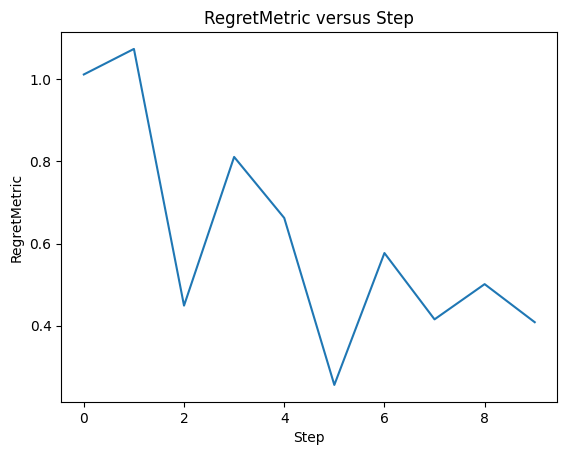

In [104]:
plot(metric_results, "RegretMetric")

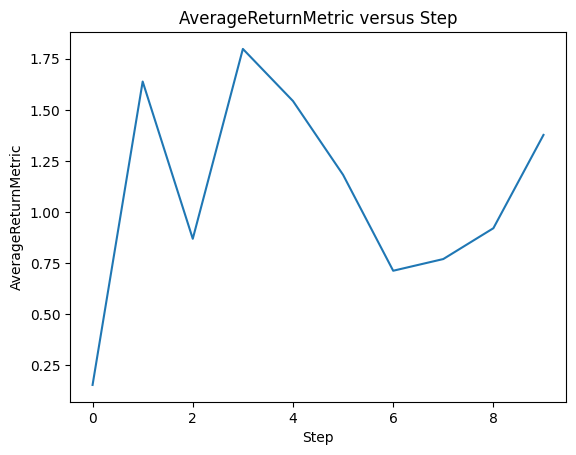

In [105]:
plot(metric_results, "AverageReturnMetric")

### Profiler

In [106]:
%load_ext tensorboard
# %reload_ext tensorboard

In [107]:
%tensorboard --logdir=$LOG_DIR

### load trained policy

In [118]:
ROOT_DIR

'gs://mabv1-hybrid-vertex-bucket/perarm-local-test/run-20230713-154556/root'

In [119]:
trained_policy = tf.saved_model.load(ROOT_DIR)
trained_policy

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7ff4b8f31ff0>

# Make predictions

In [189]:
# observation_list = [list(np.ones(RANK_K + 2)) for _ in range(BATCH_SIZE)]
# observation_list

# batched_observations = {
#     GLOBAL_KEY:
#         tf.convert_to_tensor(combined_user_features, dtype=tf.float32),
#     PER_ARM_KEY:
#         tf.convert_to_tensor(current_movies, dtype=tf.float32),
# }

# batched_observations

observation_dict = {
    GLOBAL_KEY:
        np.zeros([BATCH_SIZE, RANK_K + 2], dtype=np.int32), #making space like above for dimensions
    PER_ARM_KEY:
        np.zeros([BATCH_SIZE, NUM_ACTIONS, RANK_K + 1], dtype=np.int32),
}

print(f"observation_dict  : {observation_dict}")

observation_dict  : {'global': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32), 'per_arm': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 

In [191]:
time_step = tf_agents.trajectories.restart(
    observation=observation_dict,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)
time_step

TimeStep(
{'discount': array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 'observation': {'global': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32),
                 'per_arm': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],

In [ ]:
action_step = trained_policy.action(time_step)
action_step.action.numpy().tolist()

In [184]:
observation_array = environment._observe()

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)

action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[10, 17, 10, 15, 0, 14, 1, 15]

### debugging

In [122]:
observation_array = environment._observe()
observation_array

{'global': <tf.Tensor: shape=(8, 22), dtype=float32, numpy=
 array([[-1.2873987e-02, -2.1390352e-02,  4.6473794e-02,  1.2905279e-02,
          1.8002745e-02,  1.7323282e-02,  4.0619403e-02, -1.8831192e-03,
          3.5232522e-02, -4.7737733e-02,  3.5911977e-02,  2.8632969e-02,
          1.5208208e-03, -8.5478518e-03, -1.0778209e-02,  4.2909261e-02,
          4.1823767e-02,  2.3449438e-03, -2.0098533e-02,  5.6047082e-02,
          3.0000999e+00,  2.0000999e+00],
        [-1.7549284e-02,  3.1996551e-03,  1.8386850e-02,  1.2473919e-02,
          4.3198387e-03, -3.2752186e-02,  4.4371351e-03, -1.9762106e-02,
          1.8484747e-02, -2.2252942e-03,  1.6091483e-02,  1.3519984e-02,
         -1.0761653e-02,  8.0836611e-03, -1.6782213e-02, -4.3056097e-02,
          6.2738741e-03,  4.5072705e-02,  3.1135675e-02, -3.9139803e-02,
          2.0000999e+00,  6.0001001e+00],
        [-3.9113931e-02,  2.2795230e-02,  5.0533485e-02, -1.0424367e-02,
          2.6395298e-03,  4.1149292e-02, -3.2692634e-

In [123]:
import tf_agents

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)
time_step

TimeStep(
{'discount': <tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>,
 'observation': {'global': <tf.Tensor: shape=(8, 22), dtype=float32, numpy=
array([[-1.2873987e-02, -2.1390352e-02,  4.6473794e-02,  1.2905279e-02,
         1.8002745e-02,  1.7323282e-02,  4.0619403e-02, -1.8831192e-03,
         3.5232522e-02, -4.7737733e-02,  3.5911977e-02,  2.8632969e-02,
         1.5208208e-03, -8.5478518e-03, -1.0778209e-02,  4.2909261e-02,
         4.1823767e-02,  2.3449438e-03, -2.0098533e-02,  5.6047082e-02,
         3.0000999e+00,  2.0000999e+00],
       [-1.7549284e-02,  3.1996551e-03,  1.8386850e-02,  1.2473919e-02,
         4.3198387e-03, -3.2752186e-02,  4.4371351e-03, -1.9762106e-02,
         1.8484747e-02, -2.2252942e-03,  1.6091483e-02,  1.3519984e-02,
        -1.0761653e-02,  8.0836611e-03, -1.6782213e-02, -4.3056097e-02,
         6.2738741e-03,  4.5072705e-02,  3.1135675e-02, -3.9139803e-02,
         2.0000999e+00,  6.0001001e+00

In [124]:
action_step = trained_policy.action(time_step)
action_step

PolicyStep(action=<tf.Tensor: shape=(8,), dtype=int32, numpy=array([18,  4, 18,  8, 18,  6, 17, 14], dtype=int32)>, state=(), info=PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=<tf.Tensor: shape=(8, 21), dtype=float32, numpy=
array([[-4.07728627e-02,  3.73689756e-02,  4.69364822e-02,
        -1.36779407e-02,  4.09221426e-02,  7.41495490e-02,
         2.38642823e-02, -2.87586208e-02,  7.93194398e-02,
        -9.33892429e-02, -6.31138384e-02,  1.45214591e-02,
        -2.04371829e-02, -3.38719003e-02, -3.12873907e-02,
         1.15584182e-02, -2.91644130e-03,  1.69797353e-02,
        -1.80372801e-02,  3.16854753e-02,  7.00010014e+00],
       [-9.31553021e-02,  2.30988413e-02, -4.64833453e-02,
        -4.15738858e-03, -4.10822546e-03, -1.66582465e-02,
         1.56104028e-01, -3.71573344e-02, -3.01199071e-02,
      

In [125]:
action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[18, 4, 18, 8, 18, 6, 17, 14]

In [126]:
action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[18, 4, 18, 8, 18, 6, 17, 14]

In [127]:
observation_array = environment._observe()

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)

action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[17, 3, 1, 19, 16, 6, 12, 5]

In [128]:
observation_array = environment._observe()

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)

action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[14, 0, 13, 17, 1, 3, 3, 2]

### JT & JW sync 07/18

In [ ]:
environment._u_hat

sampled_user_ages = np.ones(BATCH_SIZE)
sampled_user_occ = np.ones(BATCH_SIZE)

SAMPLED_USER_INDICES = np.random.randint(NUM_USERS, size=BATCH_SIZE)
SAMPLED_USER_INDICES

combined_user_features = np.concatenate(
    (
        environment._u_hat[SAMPLED_USER_INDICES]
        , sampled_user_ages.reshape(-1,1)
        , sampled_user_occ.reshape(-1,1)
    )
    , axis=1
)

combined_user_features

###

import random

sampled_movie_indices = np.array([
    random.sample(range(environment._num_movies), environment._num_actions)
    for _ in range(environment._batch_size)
])

# current_users = combined_user_features.reshape([self.batch_size, self._rank_k+2])

movie_index_vector = sampled_movie_indices.reshape(-1)

flat_genre_list = environment._mov_gen_int[movie_index_vector] # shape of 1
flat_movie_list = environment._v_hat[movie_index_vector]       # shape of 2

combined_movie_features = np.concatenate(
    (
        flat_movie_list
        , flat_genre_list.reshape(-1,1)
    )
    , axis=1
)

current_movies = combined_movie_features.reshape(
    [environment._batch_size, environment._num_actions, environment._rank_k + 1]
)
current_movies
###

sampled_movie_indices.shape

observation_array = environment._observe()

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)

action_step = trained_policy.action(time_step)

action_step_np = action_step.action.numpy().tolist()
action_step_np

action_step.action
np.expand_dims(action_step.action, axis=-1)



sampled_movie_indices[:,action_step.action]
sampled_movie_indices[:,np.expand_dims(action_step.action, axis=-1)] # [:,action_step]